In [1]:
data_raw = sc.textFile('data/201508_trip_data.csv.gz')

In [2]:
data_raw.take(5)

[u'Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code',
 u'913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139',
 u'913459,1036,8/31/2015 23:11,San Antonio Shopping Center,31,8/31/2015 23:28,Mountain View City Hall,27,35,Subscriber,95032',
 u'913455,307,8/31/2015 23:13,Post at Kearny,47,8/31/2015 23:18,2nd at South Park,64,468,Subscriber,94107',
 u'913454,409,8/31/2015 23:10,San Jose City Hall,10,8/31/2015 23:17,San Salvador at 1st,8,68,Subscriber,95113']

In [3]:
from pyspark.sql import Row

In [4]:
durations = spark.createDataFrame(data_raw
             .filter(lambda x: not x.startswith('Trip'))
             .map(lambda x: x.split(','))
             .map(lambda x: Row(trip_id = int(x[0]), duration = int(x[1]))))

In [5]:
from pyspark.sql.functions import mean, stddev, udf
from pyspark.sql.types import FloatType

In [6]:
stats = durations.select(stddev(durations.duration).alias('sd'),
                         mean(durations.duration).alias('mu')).collect()

In [7]:
sd, mu = stats[0]

In [8]:
z_vals = durations.select(durations.trip_id,
                 udf(lambda x: (x - mu)/sd, FloatType())('duration').alias('z'))

In [9]:
import numpy as np

In [10]:
zs = np.array([i[0] for i in z_vals.select('z').collect()])

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

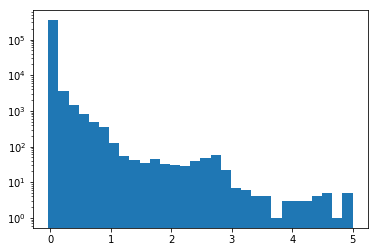

In [12]:
plt.hist(zs[zs<5],bins=30)
plt.yscale('log')
None

In [4]:
dates = (data_raw
         .map(lambda x: x.split(','))
         .map(lambda x: x[2]))

In [5]:
dates.take(5)

[u'Start Date',
 u'8/31/2015 23:26',
 u'8/31/2015 23:11',
 u'8/31/2015 23:13',
 u'8/31/2015 23:10']

In [8]:
from datetime import datetime, timedelta

In [9]:
def convert_date(date_str):
    try:
        return datetime.strptime(date_str, '%m/%d/%Y %H:%M')
    except ValueError:
        return None

In [10]:
dates = (dates
        .map(lambda x: convert_date(x))
        .filter(lambda x: x != None))

In [11]:
dates.take(5)

[datetime.datetime(2015, 8, 31, 23, 26),
 datetime.datetime(2015, 8, 31, 23, 11),
 datetime.datetime(2015, 8, 31, 23, 13),
 datetime.datetime(2015, 8, 31, 23, 10),
 datetime.datetime(2015, 8, 31, 23, 9)]

In [19]:
from operator import add

In [20]:
def seqOp(d, (h, c)):
    d[h] = c
    return d
def combOp(d1, d2):
    d1.update(d2)
    return d1

In [21]:
hourly_counts = (
    dates
    .map(lambda x: ((x.year, x.month, x.day, x.hour), 1))
    .reduceByKey(add)
    .map(lambda ((y, m, d, h), c): ((y, m, d), (h, c)))
    .aggregateByKey({}, seqOp, combOp))

In [22]:
from pyspark.ml.linalg import Vectors

In [23]:
X = (hourly_counts
     .map(lambda (day, d): (day, Vectors.dense([d.get(i, 0) for i in range(24)]))))

In [24]:
X.cache()

PythonRDD[29] at RDD at PythonRDD.scala:48

In [25]:
from pyspark.sql import Row

In [26]:
Xdf = spark.createDataFrame(X.map(lambda x: Row(features = x[1], day=x[0])))

In [27]:
from pyspark.ml.clustering import KMeans

In [28]:
Xdf.cache()

NameError: name 'X_norm' is not defined

In [98]:
ks = range(2, 10)
costs = []
for k in ks:
    costs.append(KMeans().setK(k).fit(Xdf).computeCost(Xdf))

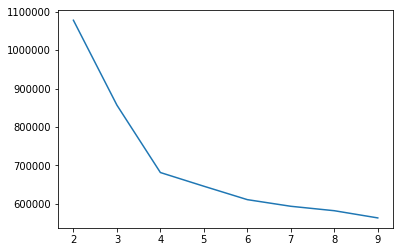

In [99]:
plt.plot(ks, costs)

In [151]:
model = KMeans().setK(4).fit(Xdf)

In [152]:
centers = [Vectors.dense(x) for x in model.clusterCenters()]

In [153]:
predictions = model.transform(Xdf)
predictions.show(5)

+------------+--------------------+----------+
|         day|            features|prediction|
+------------+--------------------+----------+
|[2014,10,25]|[4.0,4.0,5.0,1.0,...|         1|
| [2015,1,22]|[1.0,1.0,0.0,0.0,...|         2|
| [2015,6,14]|[2.0,5.0,2.0,3.0,...|         1|
| [2014,12,5]|[2.0,1.0,1.0,0.0,...|         2|
| [2014,11,6]|[2.0,0.0,2.0,0.0,...|         0|
+------------+--------------------+----------+
only showing top 5 rows



In [191]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, DateType, IntegerType, StringType
from pyspark.ml.linalg import VectorUDT

In [275]:
from calendar import day_abbr, month_abbr
from datetime import date
def get_weekday(d):
    return day_abbr[date(*d).weekday()]

In [277]:
per_weekday = predictions.select(udf(get_weekday, StringType())(predictions.day).alias('weekday'),
                  predictions.prediction.alias('class'))

In [278]:
per_weekday.show(5)

+-------+-----+
|weekday|class|
+-------+-----+
|    Sat|    1|
|    Thu|    2|
|    Sun|    1|
|    Fri|    2|
|    Thu|    0|
+-------+-----+
only showing top 5 rows



In [279]:
per_weekday.groupby('class', 'weekday').count().orderBy(per_weekday['class']).show()

+-----+-------+-----+
|class|weekday|count|
+-----+-------+-----+
|    0|    Tue|   42|
|    0|    Thu|   32|
|    0|    Wed|   39|
|    0|    Mon|   39|
|    1|    Sun|   52|
|    1|    Mon|    3|
|    1|    Thu|    4|
|    1|    Fri|    4|
|    1|    Sat|   52|
|    1|    Wed|    2|
|    2|    Tue|    6|
|    2|    Thu|   15|
|    2|    Wed|    6|
|    2|    Fri|   44|
|    2|    Mon|    7|
|    3|    Wed|    5|
|    3|    Fri|    4|
|    3|    Mon|    4|
|    3|    Tue|    4|
|    3|    Thu|    1|
+-----+-------+-----+



In [298]:
df = per_weekday.groupby('class', 'weekday').count().orderBy(per_weekday['class']).toPandas()

In [295]:
df.head()

,class,weekday,sum(class)
0,0,Wed,0
1,0,Tue,0
2,0,Thu,0
3,0,Mon,0
4,1,Thu,4


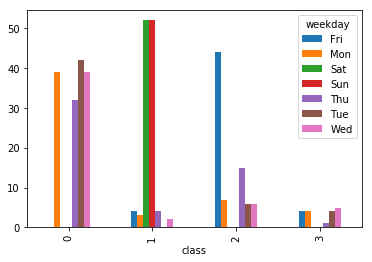

In [282]:
df.pivot_table(index='class', columns='weekday', values='count').fillna(0).plot.bar()

In [286]:
per_month = predictions.select(udf(lambda x: month_abbr[x[1]],
                                   StringType())(predictions.day).alias('month'),
                  predictions.prediction.alias('class'))

In [289]:
mdf = per_month.groupBy('month', 'class').count().toPandas()

In [290]:
mdf.head()

,month,class,count
0,Aug,2,4
1,Feb,1,9
2,Oct,1,8
3,May,1,11
4,Nov,2,7


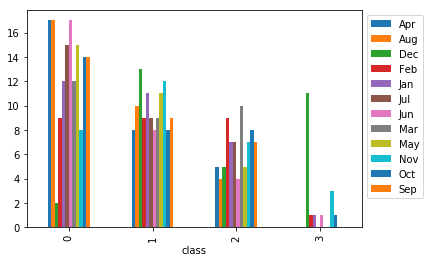

In [293]:
mdf.pivot_table(index='class', values='count', columns='month').plot.bar()
plt.legend(bbox_to_anchor=(1,1))

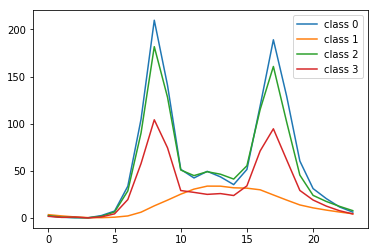

In [200]:
for n, center in enumerate(centers):
    plt.plot(center, label='class {}'.format(n))
plt.legend()

In [140]:
def dist_from_center(x, cluster):
    return float((x - centers[cluster]).norm(2))

In [141]:
d_udf = udf(dist_from_center, DoubleType())

In [167]:
dists = predictions.select(d_udf(predictions['features'], predictions['prediction']).alias('dist'),
                           predictions.day, predictions.prediction)

In [168]:
dists.orderBy(dists.dist.desc()).show(5)

+------------------+------------+----------+
|              dist|         day|prediction|
+------------------+------------+----------+
|114.50617267312238| [2015,6,10]|         3|
|103.58945260671099|[2014,12,16]|         3|
| 97.30534541798606|[2014,11,20]|         3|
| 85.53735472443857|  [2015,3,9]|         2|
| 85.06205069909734|[2014,11,19]|         3|
+------------------+------------+----------+
only showing top 5 rows



In [203]:
from pyspark.sql.functions import stddev, mean

In [206]:
dist_stats = dists.groupby('prediction').agg(stddev('dist').alias('sd'), mean('dist').alias('mu'))

In [207]:
dist_stats.show()

+----------+------------------+-----------------+
|prediction|                sd|               mu|
+----------+------------------+-----------------+
|         1|12.180383884636234|33.48106241560186|
|         3|17.617176050659342| 75.0403048706926|
|         2|12.459721867858798|45.19279417421274|
|         0| 9.411019960537754|39.86197153745228|
+----------+------------------+-----------------+



In [220]:
joined = dists.join(dist_stats, dist_stats.prediction == dists.prediction).drop(dist_stats.prediction)
joined.show()

+------------------+------------+----------+------------------+-----------------+
|              dist|         day|prediction|                sd|               mu|
+------------------+------------+----------+------------------+-----------------+
| 27.53400331046732|[2014,10,25]|         1|12.180383884636235|33.48106241560186|
|  32.1725046623595| [2015,6,14]|         1|12.180383884636235|33.48106241560186|
| 54.14622466980623| [2014,9,13]|         1|12.180383884636235|33.48106241560186|
| 30.13136432487921|  [2015,7,5]|         1|12.180383884636235|33.48106241560186|
|30.903101465405822|[2014,12,28]|         1|12.180383884636235|33.48106241560186|
| 25.80104625540358| [2015,8,29]|         1|12.180383884636235|33.48106241560186|
|25.184820516626118|  [2015,4,4]|         1|12.180383884636235|33.48106241560186|
| 65.82592925460644|  [2015,2,8]|         1|12.180383884636235|33.48106241560186|
|25.358151908515644|[2014,12,20]|         1|12.180383884636235|33.48106241560186|
|31.980121574310

In [222]:
z_vals = joined.select(udf(lambda d, mu, sd: abs(d - mu)/sd, FloatType())(
    joined.dist, joined.mu, joined.sd).alias('z'), joined.day, "prediction")

In [224]:
z_vals.orderBy(z_vals.z.desc()).show(5)

+---------+------------+----------+
|        z|         day|prediction|
+---------+------------+----------+
|3.9372978|  [2015,6,1]|         0|
|3.9098947|[2014,10,20]|         0|
| 3.554857|[2014,12,11]|         1|
|3.2379985|  [2015,3,9]|         2|
|3.1249666| [2014,9,25]|         2|
+---------+------------+----------+
only showing top 5 rows



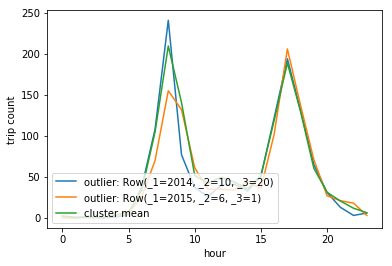

In [227]:
for day, features, cluster in predictions.rdd.filter(lambda x :x.day in (Row(2015,6,1),
                                                                         Row(2014,10,20))).collect():
    plt.plot(features, label='outlier: {}'.format(day))
plt.plot(centers[cluster], label='cluster mean')
plt.legend(loc='lower left')
plt.xlabel('hour')
plt.ylabel('trip count')

# Regression

## The Pandas Way (smaller datasets)

In [31]:
dates_frame = spark.createDataFrame(dates.map(lambda x: Row(date = x)))

In [33]:
pd_dates = dates_frame.toPandas()

In [36]:
date_counts = pd_dates.groupby('date').size()
date_counts.name = 'count'

In [41]:
hourly = date_counts.resample('1h').sum().fillna(0)

In [44]:
hourly.head(5)

date
2014-09-01 00:00:00    3.0
2014-09-01 01:00:00    0.0
2014-09-01 02:00:00    0.0
2014-09-01 03:00:00    1.0
2014-09-01 04:00:00    2.0
Freq: H, Name: count, dtype: float64

In [45]:
hourly.shift(1).head(5)

date
2014-09-01 00:00:00    NaN
2014-09-01 01:00:00    3.0
2014-09-01 02:00:00    0.0
2014-09-01 03:00:00    0.0
2014-09-01 04:00:00    1.0
Freq: H, Name: count, dtype: float64

In [42]:
shifts = {'1h': 1, '1d': 24, '1w': 7*24, '1m': 28*24}

In [43]:
import pandas

In [46]:
X = pandas.DataFrame({k: hourly.shift(shifts[k]) for k in shifts})

In [47]:
X['current'] = hourly
X = X.dropna()

In [49]:
X.head(5)

,1d,1h,1m,1w,current
date,,,,,
2014-09-29 00:00:00,7.0,1.0,3.0,2.0,1.0
2014-09-29 01:00:00,4.0,1.0,0.0,4.0,0.0
2014-09-29 02:00:00,4.0,0.0,0.0,0.0,0.0
2014-09-29 03:00:00,1.0,0.0,1.0,1.0,1.0
2014-09-29 04:00:00,1.0,1.0,2.0,1.0,3.0


In [50]:
from sklearn.ensemble import GradientBoostingRegressor

In [51]:
?GradientBoostingRegressor

In [53]:
X.index.min(), X.index.max()

(Timestamp('2014-09-29 00:00:00', freq='H'),
 Timestamp('2015-08-31 23:00:00', freq='H'))

In [64]:
split_point = '2015-8-21'
train, test = X[:split_point], X[split_point:]

In [65]:
model = GradientBoostingRegressor(loss='huber').fit(train[shifts.keys()], train.current)

In [66]:
pred = pandas.Series(model.predict(test[shifts.keys()]), index=test.index)

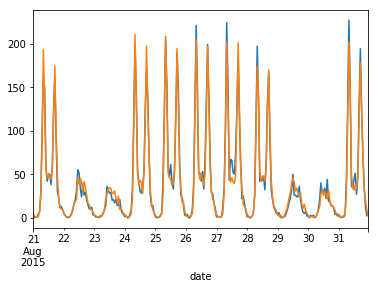

In [67]:
test.current.plot()
pred.plot()

In [68]:
errs = pred - test.current

In [69]:
mu, sigma = errs.mean(), errs.std()

In [70]:
mu, sigma

(-0.8362624197173516, 8.5451760079535219)

In [71]:
zs = errs / sigma

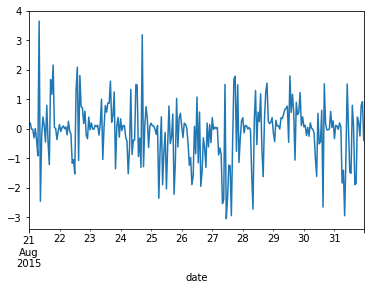

In [72]:
zs.plot.line()

## For Grownups: The Spark Way

In [13]:
?datetime

In [28]:
from operator import add

In [31]:
whole_hours = dates.map(lambda x: datetime(x.year, x.month, x.day, x.hour))

In [32]:
whole_hours = whole_hours.cache()

In [33]:
min_date, max_date = whole_hours.min(), whole_hours.max()

In [63]:
min_date, max_date

(datetime.datetime(2014, 9, 1, 0, 0), datetime.datetime(2015, 8, 31, 23, 0))

In [34]:
from datetime import timedelta

In [35]:
hours = [min_date]
while hours[-1] < max_date:
    hours.append(hours[-1] + timedelta(hours=1))

In [36]:
all_hours = sc.parallelize(((d, 0) for d in hours))

In [37]:
hourly_counts = whole_hours.map(lambda x: (x, 1)).reduceByKey(add).cache()

In [38]:
hourly_counts.take(5)

[(datetime.datetime(2014, 11, 17, 21, 0), 14),
 (datetime.datetime(2015, 7, 10, 10, 0), 55),
 (datetime.datetime(2014, 10, 14, 10, 0), 53),
 (datetime.datetime(2014, 11, 25, 19, 0), 35),
 (datetime.datetime(2015, 7, 14, 8, 0), 210)]

In [40]:
full_counts = all_hours.leftOuterJoin(hourly_counts).map(lambda (k, v): (k, max(v))).cache()

In [41]:
full_counts.take(5)

[(datetime.datetime(2014, 9, 21, 9, 0), 26),
 (datetime.datetime(2015, 3, 30, 21, 0), 22),
 (datetime.datetime(2015, 8, 31, 19, 0), 72),
 (datetime.datetime(2014, 9, 30, 4, 0), 1),
 (datetime.datetime(2015, 3, 12, 0, 0), 5)]

In [43]:
shifts = (timedelta(hours=1), timedelta(days=1), timedelta(days=7), timedelta(days=14), timedelta(days=28))

In [87]:
data = full_counts.map(lambda (d, c): (d, (c,)))
for shift in shifts:
    data = (data.join(full_counts.map(lambda (d, c) : (d + shift, c)))
                     .map(lambda (d, (t, v)): (d, t+(v,))))
data = data.cache()

In [55]:
data.take(5)

[(datetime.datetime(2015, 2, 12, 0, 0), (4, 0, 1, 6, 5, 5)),
 (datetime.datetime(2015, 3, 7, 10, 0), (28, 41, 33, 36, 35, 35)),
 (datetime.datetime(2014, 12, 18, 9, 0), (119, 39, 50, 6, 4, 149)),
 (datetime.datetime(2015, 6, 24, 18, 0), (137, 54, 138, 95, 144, 128)),
 (datetime.datetime(2015, 6, 6, 20, 0), (16, 8, 11, 11, 18, 26))]

In [57]:
from pyspark.ml.linalg import Vectors

In [88]:
X = spark.createDataFrame(data.map(lambda (d, v): Row(date=d, features=Vectors.dense(v[1:]), label=v[0])))

In [89]:
X.show(5)

+--------------------+--------------------+-----+
|                date|            features|label|
+--------------------+--------------------+-----+
|2015-02-12 00:00:...|[9.0,3.0,3.0,4.0,...|    4|
|2015-03-07 10:00:...|[24.0,41.0,16.0,2...|   28|
|2014-12-18 09:00:...|[176.0,93.0,9.0,1...|  119|
|2015-06-24 18:00:...|[192.0,132.0,128....|  137|
|2015-06-06 20:00:...|[29.0,11.0,8.0,11...|   16|
+--------------------+--------------------+-----+
only showing top 5 rows



In [60]:
from pyspark.ml.regression import GBTRegressor

In [90]:
split_point = datetime(2015,8,21)
Xtr = X.filter(X.date < split_point)
Xte = X.filter(X.date >= split_point)
model = GBTRegressor().fit(Xtr)

In [80]:
import pyspark.sql.functions as fn

In [91]:
X.agg(fn.max(X.date), fn.min(X.date)).show()

+--------------------+--------------------+
|           max(date)|           min(date)|
+--------------------+--------------------+
|2015-08-31 23:00:...|2014-09-29 00:00:...|
+--------------------+--------------------+



In [92]:
Xtr.count(), Xte.count()

(7824, 264)

In [93]:
prediction = model.transform(Xte)

In [94]:
prediction.show(5)

+--------------------+--------------------+-----+------------------+
|                date|            features|label|        prediction|
+--------------------+--------------------+-----+------------------+
|2015-08-27 11:00:...|[43.0,51.0,32.0,5...|   67| 43.85421294710714|
|2015-08-30 00:00:...|[2.0,4.0,3.0,2.0,...|    2| 3.345106034474709|
|2015-08-26 18:00:...|[199.0,151.0,129....|  139|133.61302191857968|
|2015-08-29 05:00:...|[0.0,6.0,1.0,3.0,...|    1|0.7622135948711529|
|2015-08-23 07:00:...|[2.0,8.0,3.0,6.0,...|    6| 6.083521688311659|
+--------------------+--------------------+-----+------------------+
only showing top 5 rows



In [128]:
model_result = prediction.select(
                  prediction.date,
                  prediction.label.alias('actual'),
                  prediction.prediction,
                  (prediction.prediction - prediction.label).alias('prediction error'))

In [123]:
stats = model_result.agg(fn.stddev_pop('prediction error').alias('sigma'),
                         fn.mean('prediction error')).collect()

In [124]:
stats

[Row(sigma=9.126043404991938, avg(prediction error)=-0.593727148490358)]

In [144]:
df = model_result.select((model_result['prediction error']/stats[0].sigma).alias('z'), *model_result.columns).toPandas()

In [145]:
df.head()

,z,date,actual,prediction,prediction error
0,-2.536235,2015-08-27 11:00:00,67,43.854213,-23.145787
1,0.147392,2015-08-30 00:00:00,2,3.345106,1.345106
2,-0.590286,2015-08-26 18:00:00,139,133.613022,-5.386978
3,-0.026056,2015-08-29 05:00:00,1,0.762214,-0.237786
4,0.009152,2015-08-23 07:00:00,6,6.083522,0.083522


In [146]:
%matplotlib inline

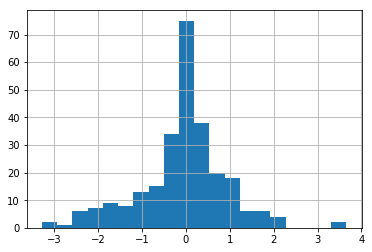

In [173]:
df.z.hist(bins=20)

In [142]:
from calendar import day_abbr, month_abbr

In [149]:
df['day'] = df.date.apply(lambda x: day_abbr[x.weekday()])
df['month'] = df.date.apply(lambda x: month_abbr[x.month])

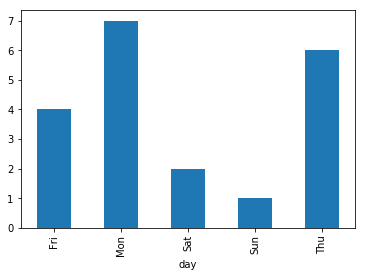

In [159]:
df[abs(df.z) > 2].groupby('day').size().plot.bar()

In [131]:
df = df.set_index('date').sort_index()

In [109]:
import matplotlib.pyplot as plt

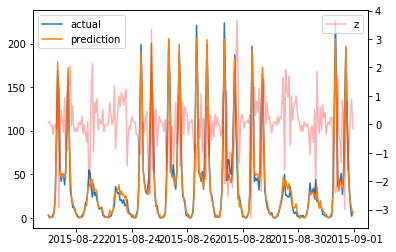

In [138]:
plt.plot(df.actual)
plt.plot(df.prediction)
plt.legend()
ax = plt.gca().twinx()
ax.plot(df.z, color='red', alpha=0.3)
plt.legend()